In [ ]:
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install transformers
# !pip install ipywidgets
# !pip install xgboost
# !pip install seaborn
# !pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for statsmodels from https://files.pythonhosted.org/packages/05/ac/4276459ea71aa46e2967ea283fc88ee5631c11f29a06787e16cf4aece1b8/statsmodels-0.14.5-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for patsy>=0.5.6 from https://files.pythonhosted.org/packages/f1/70/ba4b949bdc0490ab78d545459acd7702b211dfccf7eb89bbc1060f52818d/patsy-1.0.2-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
    --------------------------------------- 0.1/9.6 MB 2.8 MB/s eta 0:00:04
   - -------------------------------------- 0.5/9.6 MB 4.0 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/9.6 MB 5.6 MB/s eta 0:00:02
   ---- ----------------------------------- 1.1/9.6 MB 5.9 MB/s eta 0:00:02
   ----- ---------------------------------- 1.4/9.6 MB 6.


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Classic machine learning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import seaborn as sns


===== Logistic Regression =====
Accuracy: 0.9622823984526112
Precision: 0.9206349206349206


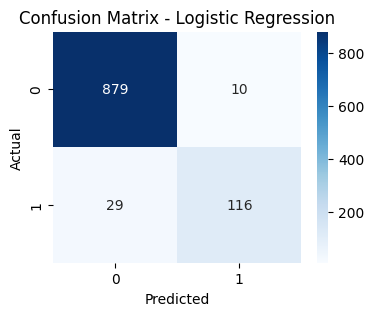


===== Decision Tree =====
Accuracy: 0.9535783365570599
Precision: 0.9801980198019802


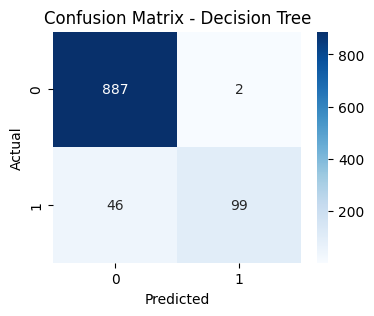


===== XGBoost =====
Accuracy: 0.9748549323017408
Precision: 0.9612403100775194


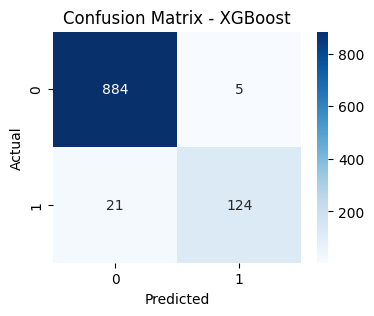


===== Gradient Boosting =====
Accuracy: 0.9700193423597679
Precision: 0.9830508474576272


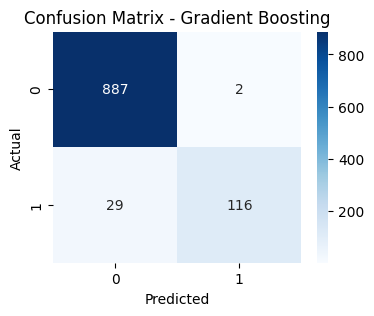

{'Logistic Regression': {'accuracy': 0.9622823984526112,
  'precision': 0.9206349206349206},
 'Decision Tree': {'accuracy': 0.9535783365570599,
  'precision': 0.9801980198019802},
 'XGBoost': {'accuracy': 0.9748549323017408, 'precision': 0.9612403100775194},
 'Gradient Boosting': {'accuracy': 0.9700193423597679,
  'precision': 0.9830508474576272}}

In [ ]:
df = pd.read_csv('spam.csv', encoding='latin-1')

# Drop unused columns
df = df[['v1','v2']]
df.rename(columns={'v1':'target','v2':'text'}, inplace=True)

encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

# Remove duplicates
df = df.drop_duplicates()

def clean_text(text):
    text = text.lower()
    return "".join([ch if ch.isalnum() else " " for ch in text])

df['transformed_text'] = df['text'].apply(clean_text)

# TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Models
clfs = {
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1'),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss"),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in clfs.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    print("Precision:", prec)

    # Heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    results[name] = {"accuracy": acc, "precision": prec}

results

In [41]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Convert X to DataFrame for readability
df_tfidf = pd.DataFrame(X[:, :200])   # first 200 features only

vif_data = pd.DataFrame()
vif_data["feature"] = df_tfidf.columns
vif_data["VIF"] = [variance_inflation_factor(df_tfidf.values, i) for i in range(df_tfidf.shape[1])]

vif_data[vif_data["VIF"] > 10]

,feature,VIF
20,20,inf
24,24,10.437247
26,26,10.026639
28,28,inf
41,41,inf
45,45,inf
46,46,inf
94,94,inf
99,99,inf
105,105,inf


# Bert Model

In [9]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
df = pd.read_csv('spam.csv', encoding="latin-1")

# changing spam classification to numeric: 0 for not spam, 1 for spam
df['label'] = df['v1'].map({'ham': 0, 'spam': 1})

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

## Prepare Dataset
- tokenizing the dataset
- padding the tokens
- tell model to ignore the padded values (aka masking)

In [12]:
tokenized = df['v2'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

print("Padded array shape:")
print(np.array(padded).shape)

attention_mask = np.where(padded != 0, 1, 0)
print("Masked data shape:")
print(attention_mask.shape)

Padded array shape:
(5572, 238)
Masked data shape:
(5572, 238)


## Using Bert
- logistic regression

In [13]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [32]:
features = last_hidden_states[0][:,0,:].numpy()
labels = df["label"]
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)


===== Logistic Regression =====
Accuracy: 0.9899497487437185
Precision: 0.9836065573770492


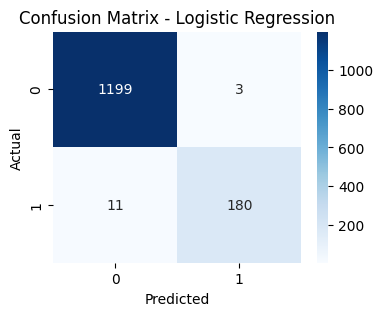


===== Decision Tree =====
Accuracy: 0.9691313711414213
Precision: 0.9302325581395349


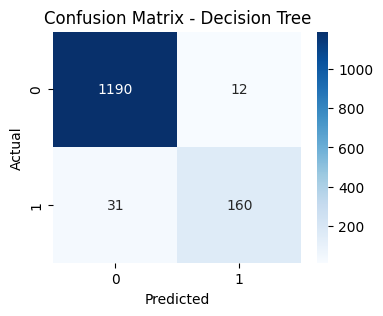


===== XGBoost =====
Accuracy: 0.9842067480258435
Precision: 0.9774011299435028


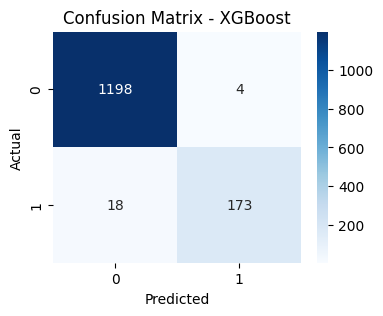


===== Gradient Boosting =====
Accuracy: 0.9849246231155779
Precision: 0.9829545454545454


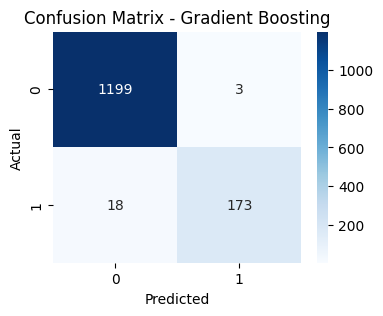

{'Logistic Regression': {'accuracy': 0.9899497487437185,
  'precision': 0.9836065573770492},
 'Decision Tree': {'accuracy': 0.9691313711414213,
  'precision': 0.9302325581395349},
 'XGBoost': {'accuracy': 0.9842067480258435, 'precision': 0.9774011299435028},
 'Gradient Boosting': {'accuracy': 0.9849246231155779,
  'precision': 0.9829545454545454}}

In [33]:
bert_models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1'),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss"),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results_bert = {}

for name, model in bert_models.items():

    # Train on full train set
    model.fit(train_features, train_labels)

    # Predict on test set
    y_pred = model.predict(test_features)

    # Metrics
    
    acc = accuracy_score(test_labels, y_pred)
    prec = precision_score(test_labels, y_pred, zero_division=0)

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    print("Precision:", prec)

    # Heatmap
    cm = confusion_matrix(test_labels, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save results
    results_bert[name] = {
        "accuracy": acc,
        "precision": prec
    }

results_bert
